In [223]:
import random
import numpy as np
import copy
import random
import itertools
import re
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt 
import cmath

from scipy.optimize import curve_fit
import sys
import multiprocessing as mp

from tqdm import tqdm
from numba import jit, cuda
benchmark = 2./3.

In [265]:
def create_init_state(max_qubits):

    all_init_states, all_init_amps = [],[]
    q_range = range(2,max_qubits+1)

    for n_q in q_range:
    
        #defining initial state
        init_state = []
        for i in range(2**n_q):
            x = [np.binary_repr(i, width=n_q)]
            res = [[int(i) for i in sub] for sub in x]
            init_state.extend(res)

        all_init_states.append(init_state)

        #generating random amplitudes
        init_amps = []
        init_amps = np.abs(np.random.uniform(0,1,2**n_q)) 
        # for i in range(2**n_q):
        #     x = cmath.rect(random.uniform(0.,1.),0.)
        #     init_amps.append(x)
        init_amps = np.sqrt(np.array(init_amps)/np.sum(np.array(init_amps))) + 0*1j

        all_init_amps.append(init_amps)
        
    return all_init_amps, all_init_states


In [3]:
def load_random_cnots_static(file):
        with open(file, 'r') as f:
            data = f.read()
        pattern = r'\[\d+(?:,\s*\d+)*\]'
        list_of_initial_cnots = [[int(cnot.split(",")[0][1]),int(cnot.split(",")[1][1])] for cnot in re.findall(pattern,data)]
        return list_of_initial_cnots

def load_random_cnots_dynamic(file):
        with open(file, 'r') as f:
            data = f.read()
        list_of_initial_cnots = [[int(cnot.split()[0]),int(cnot.split()[1])] for cnot in re.findall('\d{1,2} \d{1,2}',data)]
        return list_of_initial_cnots

In [4]:
def ordering(in_state,fi_state,o_amps):
    
    i_state = copy.deepcopy(np.array(in_state))
    f_state = copy.deepcopy(np.array(fi_state))
    new_amps = [0]*len(i_state)

    for i in range(len(i_state)):
        x = np.where((f_state == i_state[i]).all(axis=1))
        #new_amps[i] = np.sqrt(np.sum(np.array(o_amps)[x]**2))
        new_amps[i] = np.abs(np.sum(np.array(o_amps)[x]))

    new_amps = np.array(new_amps)
    return new_amps

In [5]:
def CNOT(cc,tt):
    if cc == 1:
        if tt == 1:
            tt = 0
        else:
            tt = 1

    return cc,tt

def generate_transformation_matrix(n_q,CNOT_seq):

        tmat_i = np.identity(n_q)  
        tmat_f = np.identity(n_q)  
        for i in range(0,len(CNOT_seq)):
            #print(self.CNOT_seq)
            c = int(CNOT_seq[i][0])
            t = int(CNOT_seq[i][1])

            for j in range(0,n_q):
                tmat_i[t][j] = int(tmat_i[c][j]) ^ int(tmat_i[t][j])
            
            tmat_f = tmat_i
            #self.tmat_i = np.identity(self.n_q)
        return tmat_f

def compile_circuit(num_qubits, trans_mat):
        A = copy.deepcopy(trans_mat)
        A = A.astype(np.bool_)
        gates = []
        for col in range(len(A)):
            dia_one = 1
            if A[col,col] == 0:
                dia_one = 0
            for row in range(col+1,len(A)):
                if A[row,col]==1:
                    if dia_one==0:
                        A[col] = A[col]^A[row]
                        gates.append([row,col])
                        dia_one=1
                    A[row] = A[row]^A[col]
                    gates.append([col,row])
                    
        for col in range(len(A)-1,-1,-1):
            for row in range(col-1,-1,-1):
                if A[row,col]==1:
                    A[row] = A[row]^A[col]
                    gates.append([col,row])
        assert((A==np.identity(num_qubits,dtype=np.ubyte)).all())
        return gates

def compute_t_layer_displacement_and_cnots(gates):
        displacement = 0
        displacement_list = []
        cnots = 0
        selected = [False]*len(gates)
        for idx1,gate1 in enumerate(gates):
            displacement = 0
            cnots = 0
            if selected[idx1]==True:
                continue
            cnots += 3
            displacement += (1+abs(gate1[1]-gate1[0]))
            cnots += 1
            displacement_list.append([gate1,displacement,cnots])
            #print(gate1,displacement,cnots)
            prev = gate1[1]
            selected[idx1]=True
            for idx2,gate2 in enumerate(gates[idx1+1:]):
                if selected[idx1+idx2+1]==True:
                    break
                if gate2[0]==gate1[0]:
                    selected[idx1+idx2+1]=True
                    cnots += 1
                    displacement += abs(gate2[1]-prev)
                    displacement_list.append([gate2,displacement,cnots])
                    #print(gate2,displacement,cnots)
                    prev = gate2[1]
                else:
                    break
            displacement+= (1+abs(gate1[0]-prev))
            cnots += 3
            displacement_list.append([displacement,cnots])
            #print(displacement,cnots)
        return displacement_list


def circuit(ncnots_c,cnots_c,nstates_c,states_c,amps_c,error,prob):
    
    if error == False: error = 1
    else: error = (1 + prob**2/2)/np.sqrt(2.) #error because of experiment in CNOT

    amps_fc=[0]*nstates_c
    states_fc = states_c
    power = 0

    for j in range(0,nstates_c):
        for i in range(0,ncnots_c):
            c = int(cnots_c[i][0])
            t = int(cnots_c[i][1])
            #print(c,t,j,'state:',states_fc)
            states_fc[j][c], states_fc[j][t] = CNOT(states_fc[j][c], states_fc[j][t])

            if (error and (states_fc[j][c] == 1) == True ): power = power+1

        n = np.array(states_fc[j]).tolist().count(1)
        
        #amps_fc[j] = np.array(amps_c[j])*(error**(2**(n-1)))
        amps_fc[j] = np.array(amps_c[j])*(error**(power))
        power = 0
    
    return states_fc,amps_fc

def circuit1(ncnots_c,cnots_c,nstates_c,states_c,amps_c,prob):

    phase = 0.#np.arctan((1.-prob)/(1.+prob))
    #prob = 1. - (1-prob)**2/2#np.sqrt((1 + prob**2)/2.)
    nstates = range(nstates_c)
    amp_e = copy.deepcopy(amps_c)
    for cnot in cnots_c:
        control,target = int(cnot[0]),int(cnot[1])
        for id_state in nstates:
            state = states_c[id_state]
            if state[control] == 1:
                new_val = (int(state[target])+1)%2
                state[target] = new_val
                amp_e[id_state] = cmath.rect(prob,phase)*amp_e[id_state]

    amps_c = np.array(amps_c)
    amp_e = np.array(amp_e)

    return states_c, amps_c, amp_e

def circuit_classic(ncnots_c,cnots_c,nstates_c,states_c,amps_c):

    #prob = np.sqrt((1 - prob)**2 + (prob)**2)
    nstates = range(nstates_c)
    for cnot in cnots_c:
        control,target = int(cnot[0]),int(cnot[1])
        for id_state in nstates:
            state = states_c[id_state]
            if state[control] == 1:
                new_val = (int(state[target])+1)%2
                state[target] = new_val

    amps_c = np.array(amps_c)

    return states_c, amps_c



In [384]:
def circuit_help(ncnots_c,cnots_c,nstates_c,states_c,amps_c,prob):
    
    assert np.sum(np.abs(amps_c)**2) <= 1+1e-6 and np.sum(np.abs(amps_c)**2) >= 1-1e-6

    phase = np.sqrt(1 - prob**2)*1j#np.sqrt(2*(1-prob))*1j#np.arctan((1.-prob)/(1.+prob))

    #if prob == 1: phase = 0
    #prob = 1. - (1-prob)/2 + (1-prob)/2*1j#np.sqrt((1 + prob**2)/2.)
    nstates = range(nstates_c)
    amps_c = np.array([complex(x) for x in amps_c])
    amp_e = copy.deepcopy(amps_c)
    states_c  = np.array(states_c)

    for cnot in cnots_c:
    
        control,target = int(cnot[0]),int(cnot[1])
        control_args = np.where(states_c[:,control] == 1)
        target_args0 = np.where(states_c[:,target] == 0)
        target_args1 = np.where(states_c[:,target] == 1)

        ta0 = [int(x) for x in np.intersect1d(control_args, target_args0)]
        ta1 = [int(x) for x in np.intersect1d(control_args, target_args1)]
 
        amp_e[ta0] = prob*amps_c[ta1] + phase*amps_c[ta0]
        amp_e[ta1] = prob*amps_c[ta0] + phase*amps_c[ta1]

        amps_c = copy.deepcopy(amp_e)

    #print(np.sum(np.abs(amp_e)**2))
    assert np.sum(np.abs(amp_e)**2) <= 1+1e-6 and np.sum(np.abs(amp_e)**2) >= 1-1e-6

    return states_c, amps_c, amp_e
        

In [201]:
ncnots_c = 1
cc = np.array([[0,1]])
init_amps, init_states = create_init_state(10)
nstates_c = 2**2
init_state = init_states[0]
init_amp = init_amps[0]
a,b,c,d = init_amp
print(init_amp)
print(a,b,c,d)
prob = np.cos((0.01)/2)
prob1 = np.sqrt(1-prob**2)
print(prob,1-(0.01)**2/4)
#print((2*prob**2-1)*c + 2j*prob*(np.sqrt(1-prob**2)*d))

#print('d,c', (2*prob**2-1)*d + 2j*prob*(np.sqrt(1-prob**2)*c))
#print(c*prob**2 + b*1j*prob1 + d*1j*prob*prob1)
print(b*prob**2 + c*(-prob1**2 + 1j*prob**2*prob1 ) + d*(-prob1**2*prob + 1j*prob*prob1))
print('\ninit amps',np.abs(init_amp))
c =circuit_help(ncnots_c,cc,nstates_c,init_state,init_amp,prob)
d = circuit_help(ncnots_c,cc,nstates_c,init_state,init_amp,1.)

print('\nclassical:\n', d[2],'\nactual\n',c[2])




[0.61969722+0.j 0.64875737+0.j 0.42085329+0.j 0.13405875+0.j]
(0.6196972153304122+0j) (0.6487573689408469+0j) (0.42085328782104514+0j) (0.13405874714802876+0j)
0.9999875000260416 0.999975
(0.6487272774984056+0.0027744876295700974j)

init amps [0.61969722 0.64875737 0.42085329 0.13405875]

classical:
 [0.61969722+0.j 0.64875737+0.j 0.13405875+0.j 0.42085329+0.j] 
actual
 [0.61969722+0.j         0.64875737+0.j         0.13405707+0.00210426j
 0.42084803+0.00067029j]


In [104]:
print((0.99**2-1)*0.6274152)

-0.012485562480000018


In [376]:
def operation1(case, n_qubit, init_states, init_amps, id, cnot_prob, atom_loss=1.):

    n_cnots = n_qubit//2

    #ADD YOUR PATH HERE CHETANAAA
    path = f"D:\\IITBombay\\useqip\\URA\\DIG\\quantum_volume"

    if case == 'c':
        #CLASSICAL
        # classic_file = path + '/dynamic_compiled_' + str(n_qubit) + '/circuit_' + str(id)  + '_dynamic.txt'
        # classic_circ = np.array(load_random_cnots_dynamic(classic_file))
        classic_file = path + '/cnots_' + str(n_qubit) + '/circuit_' + str(id)  + '.txt'
        classic_circ = np.array(load_random_cnots_dynamic(classic_file))
        #classic_circ = np.array([[0,1],[0,1]])
        #classical_states, classical_amps = circuit(len(classic_circ), classic_circ, len(init_states), init_states, init_amps, False, 1)
        classical_states, dum ,classical_amps = circuit_help(len(classic_circ), classic_circ, len(init_states), init_states, init_amps, 1.)
        
        #classical_amps = np.array(ordering(init_states, classical_states, classical_amps))
        return len(classic_circ), classical_amps#, classical_states

    elif case == 's':
        #STATIC
        static_file = path + '/static_compiled_' + str(n_qubit) + '/circuit_' + str(id) + '_static.txt'
        static_compiled = np.array(load_random_cnots_static(static_file))-1.
        #static_states, static_amps = circuit(len(static_compiled),static_compiled,len(init_states),init_states,init_amps, True, cnot_prob)
        static_states, dum, static_amps = circuit_help(len(static_compiled),static_compiled,len(init_states),init_states,init_amps, cnot_prob)
        #static_amps = np.array(ordering(init_states, static_states, static_amps))
        return len(static_compiled), static_amps#, static_states
    
    elif case=='du':
        #DYNAMIC UNCOMPILED
        dynamic_uncompiled_file = path + '/cnots_' + str(n_qubit) + '/circuit_' + str(id)  + '.txt'
        dynamic_notcompiled = np.array(load_random_cnots_dynamic(dynamic_uncompiled_file))

        #dynamic_notcompiled_states, dynamic_notcompiled_amps =  circuit(len(dynamic_notcompiled), dynamic_notcompiled, len(init_states), init_states, init_amps, True, cnot_prob)
        dynamic_notcompiled_states, dum, dynamic_notcompiled_amps =  circuit_help(len(dynamic_notcompiled), dynamic_notcompiled, len(init_states), init_states, init_amps, cnot_prob)
        #dynamic_notcompiled_amps = np.array(ordering(init_states, dynamic_notcompiled_states, dynamic_notcompiled_amps))
        if atom_loss==1:
            #WITHOUT ATOM LOSS
            return len(dynamic_notcompiled), dynamic_notcompiled_amps#, dynamic_notcompiled_states,
        else:
            #WITH ATOM LOSS
            disp_notcompiled = compute_t_layer_displacement_and_cnots(dynamic_notcompiled)
            total_disps_notcompiled = 0.
            for i in disp_notcompiled: 
                if len(i)==2: total_disps_notcompiled += i[0] 
            dynamic_notcompiled_disp_amps = np.array(dynamic_notcompiled_amps)*atom_loss**total_disps_notcompiled
            return len(dynamic_notcompiled), dynamic_notcompiled_disp_amps#, dynamic_notcompiled_states
    
    elif case=='dc':

        #DYNAMIC COMPLIED WITHOUT ATOM LOSS
        dynamic_compiled_file = path + '/dynamic_compiled_' + str(n_qubit) + '/circuit_' + str(id)  + '_dynamic.txt'
        dynamic_compiled = np.array(load_random_cnots_dynamic(dynamic_compiled_file))[::-1]
        #print(dynamic_compiled)
        #dynamic_compiled = np.array([[0,1],[0,1]])
        #print(dynamic_compiled)

        #dynamic_compiled_states, dynamic_compiled_amps = circuit(len(dynamic_compiled), dynamic_compiled, len(init_states), init_states, init_amps, True, cnot_prob)
        dynamic_compiled_states, dum, dynamic_compiled_amps = circuit_help(len(dynamic_compiled), dynamic_compiled, len(init_states), init_states, init_amps, cnot_prob)
        #dynamic_compiled_amps = np.array(ordering(init_states, dynamic_compiled_states, dynamic_compiled_amps))
        if atom_loss==1:
            #WITHOUT ATOM LOSS
            return len(dynamic_compiled), dynamic_compiled_amps#, dynamic_compiled_states  
        else:
            #WITH ATOM LOSS
            disp_compiled = compute_t_layer_displacement_and_cnots(dynamic_compiled)
            total_disps_compiled = 0.
            for i in disp_compiled: 
                if len(i)==2: total_disps_compiled += i[0] 
            dynamic_compiled_disp_amps = np.array(dynamic_compiled_amps)*atom_loss**total_disps_compiled
            return len(dynamic_compiled), dynamic_compiled_disp_amps#, dynamic_compiled_states

    else:
        raise Exception("Only acceptible cases are \n classical: c \n static: s \n dynamic uncompiled: ud \n dynamic compiled: dc")

In [9]:
def hop_calc(case, max_qubits, init_amps, init_states, cnot_prob, atom_loss, n_trials):

    cnots_c, cnots, all_qubits_hps = [0]*(max_qubits-1),[0]*(max_qubits-1),[0]*(max_qubits-1)
    qubit_range = range(2,max_qubits+1)
    ncnots_c, ncnots = [0]*n_trials,[0]*n_trials

    for n_qubits in qubit_range:

        #initializing states, amps and hps

        init_state = init_states[n_qubits-2]
        init_amp = init_amps[n_qubits-2]

        #all_states_c, all_states = np.empty([n_trials, 2**n_qubits, n_qubits]), np.empty([n_trials, 2**n_qubits, n_qubits])
        #all_amps_c, all_amps = np.empty([n_trials,2**n_qubits]), np.empty([n_trials,2**n_qubits])
        all_hp = np.empty([n_trials])
        #paper_all_qv = np.empty([n_trials])

        #states_c, amps_c, states, amps = init_state, init_amp, init_state, init_amp

        for i in range(n_trials):

            ncnots_c[i], famps_c = operation1('c', n_qubits, init_state, init_amp, i, cnot_prob)
            ncnots[i], famps = operation1(case, n_qubits, init_state, init_amp, i, cnot_prob, atom_loss)

            probs_ascending_order_c = np.argsort(famps_c**2)
            probs_ascending_order = np.argsort(famps**2)
            sorted_probs_c = np.array(famps_c**2)[probs_ascending_order_c]
            sorted_probs = np.array(famps**2)[probs_ascending_order]

            median_classical = np.median(sorted_probs_c)

            hp = np.sum(sorted_probs[sorted_probs > median_classical])
            #paper_qv = len(sorted_probs[sorted_probs > median_classical])
            #paper_all_qv[i] = paper_qv  
            all_hp[i] = hp
            #all_states_c[i], all_amps_c[i], all_states[i], all_amps[i] = np.array(states_c), np.array(amps_c), np.array(states), np.array(amps)
            #all_states_c[i], all_amps_c[i], all_states[i], all_amps[i] = np.array(states_c), np.array(amps_c), np.array(states), np.array(amps)

        cnots_c[n_qubits-2] = np.mean(ncnots_c)
        cnots[n_qubits-2] = np.mean(ncnots)

        case_hp = np.mean(all_hp)
        #paper_case_qv = (np.mean(paper_all_qv) - 2*np.sqrt(np.mean(paper_all_qv)*(1-np.mean(paper_all_qv)/n_trials)))/n_trials

        QV = np.max(qubit_range)
        if case_hp < benchmark:         
            QV = n_qubits-1
            break

        all_qubits_hps[n_qubits-2] = case_hp
    
    return QV, cnots, all_qubits_hps
        

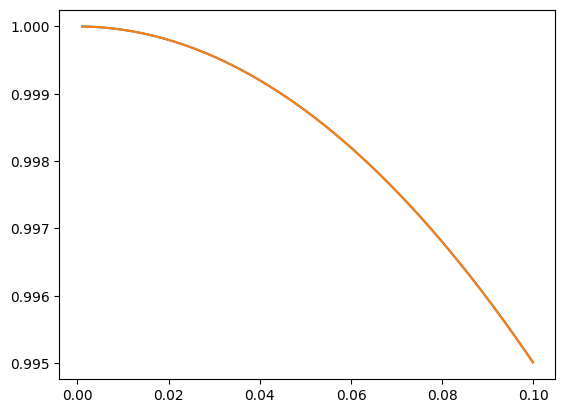

In [175]:
x = np.arange(0.001,0.1,0.0001)
plt.plot(x,np.cos(x))
plt.plot(x,1 - x**2/2)

In [415]:
#TO FIND MAXIMUM ERROR
def isHeavy(case, n_qubits, i_amps, i_states, cnot_prob, atom_loss, n_trials):

    ncnots_c, ncnots = [0]*n_trials,[0]*n_trials
    QV = True
    
    all_hp = np.empty([n_trials])
    #print(cnot_prob,'\n')
    a,b,c,d = i_amps[0:4]
    #print((2*cnot_prob**2-1)*c + 2j*cnot_prob*(np.sqrt(1-cnot_prob**2)*d))

    #print('d,c', (2*cnot_prob**2-1)*d + 2j*cnot_prob*(np.sqrt(1-cnot_prob**2)*c))
    for i in range(n_trials):

        #print('initial median: ', np.median(np.sort(np.abs(i_amps)**2)))
        ncnots_c[i], famps_c = operation1('c', n_qubits, i_states, i_amps, i, cnot_prob)
        ncnots[i], famps = operation1(case, n_qubits, i_states, i_amps, i, cnot_prob, atom_loss)
        #print('evolved probs:')
        #for k in range(len(i_states)): print( i_states[k],': ', np.array(famps_c)[k], np.array(famps)[k])
        #print('\n')
        

        probs_ascending_order_c = np.argsort(np.abs(famps_c)**2)
        probs_ascending_order = np.argsort(np.abs(famps)**2)
        sorted_probs_c = np.array(np.abs(famps_c)**2)[probs_ascending_order_c]
        sorted_probs = np.array(np.abs(famps)**2)[probs_ascending_order]
        median_classical = np.median(sorted_probs_c)
        
        sorted_states = copy.deepcopy(i_states)
        #print('sorted:')
        #for k in range(len(i_states)):print(np.array(i_states)[probs_ascending_order_c][k],': ', sorted_probs_c[k], np.array(sorted_states)[probs_ascending_order][k],': ',sorted_probs[k])
        #print([probs_ascending_order_c[len(probs_ascending_order_c)//2:]], np.array(np.abs(famps)**2)[probs_ascending_order_c[len(probs_ascending_order_c)//2:]])
        hp = np.sum(np.array(np.abs(famps)**2)[probs_ascending_order_c[len(probs_ascending_order_c)//2:]])
        hp_c = np.sum(np.array(np.abs(famps_c)**2)[probs_ascending_order_c[len(probs_ascending_order_c)//2:]])
        #print('median: ',median_classical,'hp_c: ', hp_c,'hp: ',hp,'\n')
        
        all_hp[i] = hp

    cnots_c = np.mean(ncnots_c)
    cnots = np.mean(ncnots)

    case_hp = np.mean(all_hp)
        #paper_case_qv = (np.mean(paper_all_qv) - 2*np.sqrt(np.mean(paper_all_qv)*(1-np.mean(paper_all_qv)/n_trials)))/n_trials

    if case_hp < benchmark:         
        QV = False

    all_qubits_hps = case_hp
    
    return QV, cnots, all_qubits_hps
        

n_qubit = 7

n_trials = 999#min(999,2**max_qubits)
benchmark = 2./3.
atom_loss = 1.
# err_prob = x = np.arange(0.15,0.8,0.01)
# err_prob = np.cos(err_prob)
err_prob = np.arange(0.999,0.99999,0.00001)
err_prob = np.sqrt(4 - 5*(1-err_prob)) - 1
print(err_prob)
trials = 50
all_mer = [0]*trials
init_amps, init_states = create_init_state(n_qubit)
istate = init_states[n_qubit - 2]
iamp = init_amps[n_qubit - 2]
# iamp[0:4] = np.array([0.61969722+0.j, 0.64875737+0.j, 0.42085329+0.j, 0.13405875+0.j])
# iamp[4:] = 0
# x = np.empty([len(err_prob)])
# for i in tqdm(range(len(err_prob))):
#     x[i] = isHeavy('dc', n_qubit, iamp, istate, err_prob[i], atom_loss, n_trials)[2]
#     print(x[i])

# plt.plot(x,err_prob)
# plt.show()


for i in tqdm(range(trials)):
    init_amps, init_states = create_init_state(n_qubit)
    istate = init_states[n_qubit - 2]
    iamp = init_amps[n_qubit - 2]

    # iamp[:] = 0
    # iamp[-1] = 1.
    # iamp[0:4] = np.array([0.61969722+0.j, 0.64875737+0.j, 0.42085329+0.j, 0.13405875+0.j])
    # iamp[4:] = 0

    left, right = 0, len(err_prob) - 1
    result = None
    #for k in range(len(istate)): print(istate[k],': ', iamp[k])
    #print('\n')

    # for i in range(len(err_prob)):
    #     pr = isHeavy('dc', n_qubit, iamp, istate, err_prob[i], atom_loss, n_trials)
    #     #print('final',err_prob[i],1-(2+err_prob[i]*2+err_prob[i]**2)/5.,pr[2])

    while left <= right:
        
        mid = left + (right - left) // 2
        #print(err_prob[mid],np.arccos(err_prob[mid]),1 - (2 + 2*err_prob[mid]+err_prob[mid]**2)/5, isHeavy('dc', n_qubit, iamp, istate, err_prob[mid], atom_loss, n_trials)[2])
        if not isHeavy('s', n_qubit, iamp, istate, err_prob[mid], atom_loss, n_trials)[0]:
            result = err_prob[mid]
            left = mid + 1
        else:
            right = mid - 1
    all_mer[i] = result
    print(result)
    
error = 1-(2+np.array(all_mer)*2+np.array(all_mer)**2)/5.         
print(np.mean(error), np.std(error))



[0.99874961 0.99876212 0.99877462 0.99878713 0.99879964 0.99881215
 0.99882465 0.99883716 0.99884967 0.99886218 0.99887468 0.99888719
 0.9988997  0.9989122  0.99892471 0.99893722 0.99894972 0.99896223
 0.99897474 0.99898724 0.99899975 0.99901226 0.99902476 0.99903727
 0.99904977 0.99906228 0.99907479 0.99908729 0.9990998  0.9991123
 0.99912481 0.99913731 0.99914982 0.99916232 0.99917483 0.99918733
 0.99919984 0.99921234 0.99922485 0.99923735 0.99924986 0.99926236
 0.99927487 0.99928737 0.99929988 0.99931238 0.99932489 0.99933739
 0.99934989 0.9993624  0.9993749  0.99938741 0.99939991 0.99941241
 0.99942492 0.99943742 0.99944992 0.99946243 0.99947493 0.99948743
 0.99949994 0.99951244 0.99952494 0.99953745 0.99954995 0.99956245
 0.99957495 0.99958746 0.99959996 0.99961246 0.99962496 0.99963747
 0.99964997 0.99966247 0.99967497 0.99968748 0.99969998 0.99971248
 0.99972498 0.99973748 0.99974998 0.99976249 0.99977499 0.99978749
 0.99979999 0.99981249 0.99982499 0.99983749 0.99984999 0.99986

  2%|▏         | 1/50 [00:55<45:17, 55.47s/it]

0.999462427754017


  4%|▍         | 2/50 [01:43<40:47, 50.99s/it]

0.9995124405714473


  6%|▌         | 3/50 [02:39<41:56, 53.54s/it]

0.9994999374843667


  8%|▊         | 4/50 [03:36<41:54, 54.66s/it]

0.9996874755821177


 10%|█         | 5/50 [04:31<41:15, 55.01s/it]

0.999462427754017


 12%|█▏        | 6/50 [05:26<40:13, 54.86s/it]

0.9995374465110638


 14%|█▍        | 7/50 [06:21<39:15, 54.79s/it]

0.9995999599919942


 16%|█▌        | 8/50 [07:15<38:17, 54.71s/it]

0.9994249173199747


 18%|█▊        | 9/50 [08:10<37:23, 54.73s/it]

0.9994999374843667


 20%|██        | 10/50 [09:04<36:25, 54.65s/it]

0.9995624521379634


 22%|██▏       | 11/50 [09:52<34:07, 52.51s/it]

0.9994749310756528


 24%|██▍       | 12/50 [10:47<33:48, 53.39s/it]

0.999462427754017


 26%|██▌       | 13/50 [11:43<33:14, 53.89s/it]

0.9995374465110638


 28%|██▊       | 14/50 [12:38<32:32, 54.24s/it]

0.9996624715186269


 30%|███       | 15/50 [13:33<31:56, 54.75s/it]

0.9996374671424777


 32%|███▏      | 16/50 [14:29<31:09, 54.97s/it]

0.9995249435803459


 34%|███▍      | 17/50 [15:24<30:15, 55.02s/it]

0.9995624521379634


 36%|███▌      | 18/50 [16:19<29:20, 55.02s/it]

0.9994499243541928


 38%|███▊      | 19/50 [17:14<28:28, 55.11s/it]

0.9995999599919942


 40%|████      | 20/50 [18:09<27:30, 55.03s/it]

0.9995249435803459


 42%|████▏     | 21/50 [19:05<26:39, 55.16s/it]

0.9995249435803459


 44%|████▍     | 22/50 [20:00<25:42, 55.09s/it]

0.9996499693696355


 46%|████▌     | 23/50 [20:55<24:46, 55.06s/it]

0.9994499243541928


 48%|████▊     | 24/50 [21:50<23:51, 55.04s/it]

0.999462427754017


 50%|█████     | 25/50 [22:45<22:54, 55.00s/it]

0.9996249648371527


 52%|█████▏    | 26/50 [23:39<21:57, 54.92s/it]

0.999462427754017


 54%|█████▍    | 27/50 [24:26<20:08, 52.52s/it]

0.9995874574521577


 56%|█████▌    | 28/50 [25:13<18:39, 50.91s/it]

0.9994374208761792


 58%|█████▊    | 29/50 [26:11<18:31, 52.94s/it]

0.9994124136855778


 60%|██████    | 30/50 [26:58<17:03, 51.18s/it]

0.9995874574521577


 62%|██████▏   | 31/50 [27:51<16:24, 51.79s/it]

0.9994874343191023


 64%|██████▍   | 32/50 [28:45<15:41, 52.30s/it]

0.9995999599919942


 66%|██████▌   | 33/50 [29:31<14:19, 50.56s/it]

0.9995124405714473


 68%|██████▊   | 34/50 [30:27<13:54, 52.18s/it]

0.9994874343191023


 70%|███████   | 35/50 [31:22<13:15, 53.05s/it]

0.9994249173199747


 72%|███████▏  | 36/50 [32:17<12:27, 53.39s/it]

0.9995374465110638


 74%|███████▍  | 37/50 [33:12<11:42, 54.02s/it]

0.9995624521379634


 76%|███████▌  | 38/50 [34:07<10:50, 54.21s/it]

0.9993749023132177


 78%|███████▊  | 39/50 [34:53<09:29, 51.75s/it]

0.9995124405714473


 80%|████████  | 40/50 [35:48<08:48, 52.85s/it]

0.9994874343191023


 82%|████████▏ | 41/50 [36:35<07:39, 51.05s/it]

0.9995124405714473


 84%|████████▍ | 42/50 [37:30<06:57, 52.19s/it]

0.9995374465110638


 86%|████████▌ | 43/50 [38:25<06:11, 53.08s/it]

0.9994999374843667


 88%|████████▊ | 44/50 [39:20<05:22, 53.74s/it]

0.9993749023132177


 90%|█████████ | 45/50 [40:15<04:30, 54.09s/it]

0.9996249648371527


 92%|█████████▏| 46/50 [41:02<03:28, 52.00s/it]

0.9994749310756528


 94%|█████████▍| 47/50 [41:57<02:38, 52.92s/it]

0.9993874061822008


 96%|█████████▌| 48/50 [42:55<01:48, 54.36s/it]

0.9995749548341479


 98%|█████████▊| 49/50 [43:51<00:54, 54.73s/it]

0.9996249648371527


100%|██████████| 50/50 [44:48<00:00, 53.76s/it]

0.9994124136855778
0.00038560000000282147 6.119346370294897e-05


In [397]:
print(all_mer)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [10]:
max_qubits = 10
n_trials = 100#min(999,2**max_qubits)
benchmark = 2./3.
atom_loss = 1
q_range = range(3,max_qubits+1)
atom_loss = 1.

init_amps, init_states = create_init_state(max_qubits)

a1 =  np.logspace(-3, -2, 3)
a2 = np.arange(1,10,1)
err_probg = np.outer(a1, a2).flatten()
probg = 1 - np.outer(a1, a2).flatten()
eff_cnot = np.copy(probg)

qubits = range(2,max_qubits+1)
eff_cnot = [0.]*100
slope = np.copy(qubits)
eff_errorc = np.empty(len(probg))
eff_error_limsc = np.empty(len(probg))
ncnots_c, ncnots = [0]*n_trials,[0]*n_trials
fit_A, fit_B = [0]*len(probg),[0]*len(probg)

In [99]:
a1 =  np.logspace(-3, -2, 3)
a2 = np.arange(1,10,1)
err_probg = np.outer(a1, a2).flatten()
probg = 1 - np.outer(a1, a2).flatten()


for j in qubits:
    for id in range(100):
        ncnots_c[id], famps_c = operation1('c', j, init_states[j-2], init_amps[j-2], id+6, probg[k])
        ncnots[id], famps = operation1('dc', j, init_states[j-2], init_amps[j-2], id+6, probg[k], atom_loss)
        eff_cnot[id] = np.sum(famps*famps_c)

    eff_errorc[j-2] = np.mean(eff_cnot)
    eff_error_limsc[j-2] = np.std(eff_cnot)



100%|██████████| 27/27 [06:32<00:00, 14.56s/it]


In [98]:
print(eff_errorc,'\nhello\n', eff_error_limsc)

[[0.99970053 0.99914884 0.99736611 0.99511167 0.99136346 0.98743388
  0.98152822 0.97536839 0.96881347]
 [0.99939411 0.99825345 0.99466766 0.99023451 0.98281748 0.97518267
  0.96356458 0.95144677 0.93862708]
 [0.99907696 0.99743346 0.99204961 0.98533899 0.9743045  0.9629041
  0.94581845 0.9281096  0.90954554]
 [0.99880344 0.99651599 0.98949847 0.9802928  0.96598489 0.95086311
  0.92836015 0.90530827 0.88128249]
 [0.99848698 0.99570946 0.98681758 0.97545285 0.95755623 0.93893329
  0.9113789  0.88319206 0.85401375]
 [0.99815603 0.99490119 0.98395617 0.97073453 0.94949237 0.92717938
  0.89458996 0.86163264 0.82746012]
 [0.99790836 0.99384246 0.98191382 0.96600717 0.94101144 0.91556258
  0.87845435 0.84053299 0.80191091]
 [0.99758189 0.99323192 0.9791764  0.96151428 0.9332259  0.90450543
  0.86240924 0.81991995 0.77711046]
 [0.99723722 0.9921876  0.9762868  0.9570184  0.92522341 0.89334286
  0.84680803 0.79989811 0.75322101]
 [0.99905374 0.997295   0.99162187 0.98461188 0.9729402  0.960887

Ax+B:  [1.84204338e+00 3.22184925e-09] 

Ax^2+B:  [0.0222137  2.51563934] 

Ax^2+Bx+C:  [1.85924815e-02 5.81418426e-01 5.25963066e-04] 

Ax^B+C:  [0.06665697 2.54016105 1.1693907 ] 

Ax^2:  [0.02604212] 

err*(Ax^B+C):  [0.06665697 2.54016105 1.1693907 ]


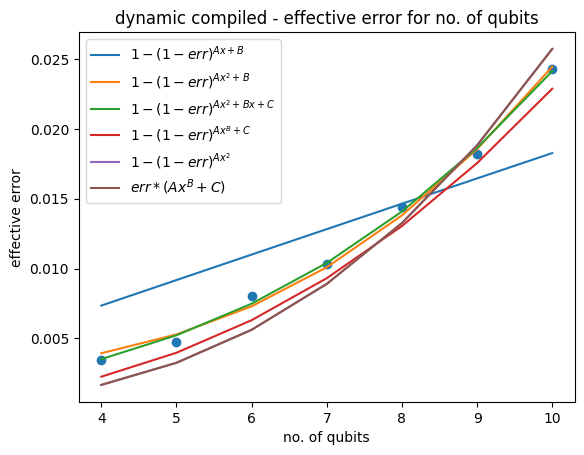

In [119]:
qubits = np.arange(4,11)
probc = 0.999
outp = 1 - np.array(eff_errorc**2)[0,2:]
inp = qubits

def fit1(X,A,B):
    x = X
    return 1 - (probc)**(A*x + B)
    
def fit2(X,A,B):
    x = X
    return 1 - (probc)**(A*x*x*x + B)

def fit3(X,A,B,C):
    x = X
    return 1 - (probc)**(A*x*x*x + B*x+C)

def fit4(X,A,B,C):
    x = X
    return 1 - (probc)**(A*x**B + C)

def fit5(X,A):
    x = X
    return 1 - (probc)**(A*x*x*x)

def fit6(X,A,B,C):
    x = X
    return (1 - probc)*(A*x*B + C)


params1, cov1 = curve_fit(fit1,inp,outp,bounds=((0., 0.), (np.inf, np.inf)))
fit1a, fit1b = params1[0], params1[1]
params2, cov2 = curve_fit(fit2,inp,outp,bounds=((0., 0.), (np.inf, np.inf)))
fit2a, fit2b = params2[0], params2[1]
params3, cov3 = curve_fit(fit3,inp,outp,bounds=((0., 0., 0.), (np.inf, np.inf, np.inf)))
fit3a, fit3b, fit3c = params3[0], params3[1], params3[2]
params4, cov4 = curve_fit(fit4,inp,outp,bounds=((0., 0., 0.), (np.inf, np.inf, np.inf)))
fit4a, fit4b, fit4c = params4[0], params4[1], params4[2]
params5, cov5 = curve_fit(fit5,inp,outp,bounds=((0.), (np.inf)))
fit5a = params5
params6, cov6 = curve_fit(fit4,inp,outp,bounds=((0., 0., 0.), (np.inf, np.inf, np.inf)))
fit6a, fit6b, fit6c = params6[0], params6[1], params6[2]

print('Ax+B: ',params1,'\n\nAx^2+B: ', params2,'\n\nAx^2+Bx+C: ',params3,'\n\nAx^B+C: ',params4,'\n\nAx^2: ',params5,'\n\nerr*(Ax^B+C): ',params6)

plot_err = [0.999]*len(probg)
plot_inp = qubits
fity1 = fit1(plot_inp,fit1a,fit1b)
ploty1 = fity1#.reshape(len(probg),len(qubits))[1]
fity2 = fit2(plot_inp,fit2a,fit2b)
ploty2 = fity2#.reshape(len(probg),len(qubits))[1]
fity3 = fit3(plot_inp,fit3a,fit3b,fit3c)
ploty3 = fity3#.reshape(len(probg),len(qubits))[1]
fity4 = fit4(plot_inp,fit4a,fit4b,fit3c)
ploty4 = fity4#.reshape(len(probg),len(qubits))[1]
fity5 = fit5(plot_inp,fit5a)
ploty5 = fity5#.reshape(len(probg),len(qubits))[1]
fity6 = fit6(plot_inp,fit6a,fit6b,fit6c)
ploty6 = fity6
plt.title('dynamic compiled - effective error for no. of qubits')
plt.ylabel('effective error')
plt.xlabel('no. of qubits')
plt.plot(qubits,ploty1, label = '$1-(1-err)^{Ax+B}$')
plt.plot(qubits,ploty2, label = '$1-(1-err)^{Ax^2+B}$')
plt.plot(qubits,ploty3, label = '$1-(1-err)^{Ax^2+Bx+C}$')
plt.plot(qubits,ploty4, label = '$1-(1-err)^{Ax^B+C}$')
plt.plot(qubits,ploty5, label = '$1-(1-err)^{Ax^2}$')
plt.plot(qubits,ploty5, label = '$err*(Ax^B+C)$')
plt.scatter(qubits,outp)
plt.legend()



5 [0.07293816 0.06639603 0.06551203 0.06521114 0.05524602]


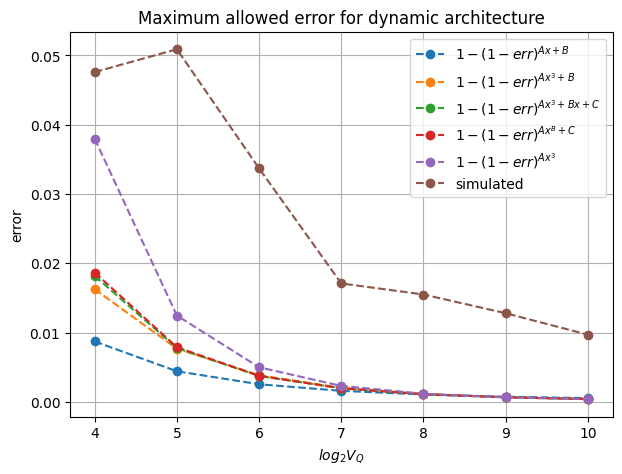

In [120]:
max_qubits = 10
m = np.array(range(4, max_qubits+1))
n = m*m//2

max_error_dynamic = 1 - np.array([0.9524, 0.9491, 0.9663, 0.9829, 0.9845, 0.9872, 0.9903])

error1 = 1 - (1-1/m**2)**(1/(fit1a*m+fit1b))
error2 = 1 - (1-1/m**2)**(1/(fit2a*m**3 + fit2b))
error3 = 1 - (1-1/m**2)**(1/(fit3a*m**3 + fit3b*m+fit3c))
error4 = 1 - (1-1/m**2)**(1/(fit4a*m**fit4b + fit4c))
error5 = 1 - (1-1/m**2)**(1/(fit5a*m**3))
#error6 = 1 - (1-1/m**2)**(1/fit6(m,fit6a,fit6b,fit6c))

rms1 = np.sqrt(np.sum((max_error_dynamic - error1)**2))
rms2 = np.sqrt(np.sum((max_error_dynamic - error2)**2))
rms3 = np.sqrt(np.sum((max_error_dynamic - error3)**2))
rms4 = np.sqrt(np.sum((max_error_dynamic - error4)**2))
rms5 = np.sqrt(np.sum((max_error_dynamic - error5)**2))
#rms6 = np.sqrt(np.sum((max_error_dynamic - error6)**2))

rms = np.array([rms1, rms2, rms3, rms4, rms5])
print(np.argmin(rms)+1, rms)


fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(m,error1,'o--', label = '$1-(1-err)^{Ax+B}$')
ax.plot(m,error2,'o--', label = '$1-(1-err)^{Ax^3+B}$')
ax.plot(m,error3, 'o--',label = '$1-(1-err)^{Ax^3+Bx+C}$')
ax.plot(m,error4,'o--', label = '$1-(1-err)^{Ax^B+C}$')
ax.plot(m,error5,'o--', label = '$1-(1-err)^{Ax^3}$')
ax.plot(m,max_error_dynamic,'o--', label = 'simulated')
#ax.plot(fitme,errorfit)
#ax.set_yscale('log')
plt.xlabel("$log_2V_Q$")
plt.ylabel("error")
plt.title("Maximum allowed error for dynamic architecture")
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


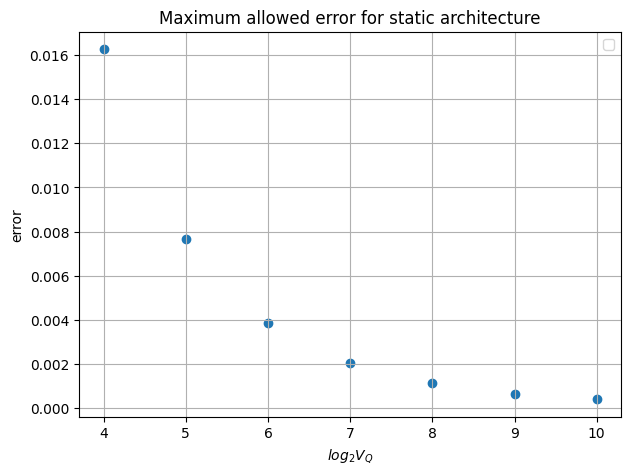

In [110]:
#Dynamic: A: 0.11963158486882755 B: -4.0902778447768e-07 C: -0.4033038136161962
#Static: A: 0.3191742863897495 B: 6.835925253072445e-08 C: -2.1805217046206127

#Dynamic: Ax^2+Bx+C
#0.11211913524174104 2.242464930836841e-06 1.3100450600199236e-06 [[ 0.00072523 -0.00794162  0.0179514 ]
# [-0.00794162  0.08987092 -0.2123746 ]
# [ 0.0179514  -0.2123746   0.5454004 ]]

#Static: Ax^2 + Bx + C
# 0.2779657981233793 1.8344082241153934e-11 3.5727103802444097e-12 [[ 0.02389208 -0.2598694   0.58274047]
# [-0.2598694   2.92259597 -6.85134836]
# [ 0.58274047 -6.85134836 17.45043685]]


max_qubits = 10
m = np.array(range(4, max_qubits+1))
n = m*m//2

error2 = 1 - (1-1/m**2)**(1/(fit2a*m**3 + fit2b))

fitme = np.arange(6,14,0.1)
nfit = fitme*fitme//2

fig, ax = plt.subplots(figsize = (7, 5))
ax.scatter(m,error2)
#ax.plot(fitme,errorfit)
#ax.set_yscale('log')
plt.xlabel("$log_2V_Q$")
plt.ylabel("error")
plt.title("Maximum allowed error for static architecture")
plt.legend()
plt.grid()

Text(0, 0.5, 'error')

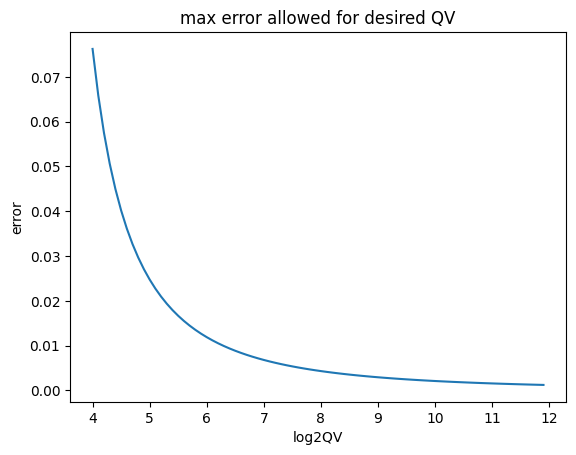

In [76]:
max_qubits = 16
#m = np.arange(8,max_qubits+1)
m = np.arange(4,12,0.1)
plt.plot(m,1/((s*np.sqrt(m)+c)*m**2))
plt.title('max error allowed for desired QV')
plt.xlabel('log2QV')
plt.ylabel('error')

In [71]:
print(np.std(all_mer))
final_dc = 0.962
print(1 - (2 + 2*final_dc + final_dc**2)/(5))

0.003083439637806764
0.030111200000000005


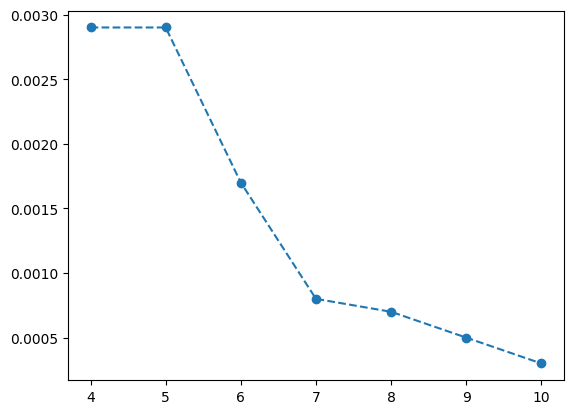

In [ ]:
killme2dc = np.array([0.994649999, 0.996809999, 0.93755999999, 0.93722999999])
killme2dcsd = np.array([0.003068, 0.00083839, 0.01211942, 0.0086627])


killme_dc = np.sqrt(2*(1 - np.array([0.969129999, 0.9813299, 0.98709999999, 0.9896599999, 0.992719999, 0.994229999])))
killmestd_dc = np.array([0.0678199, 0.04189081, 0.014090, 0.011457, 0.0064471, 0.0027131500])

max_error_dc95 = 1 - np.array([0.9584, 0.9558, 0.9750, 0.9910, 0.9927, 0.9957, 0.9987])
max_error_dc97 = 1 - np.array([0.9555, 0.9523, 0.9716, 0.9875, 0.9893, 0.9922, 0.9954])
max_error_dc93 = 1 - np.array([0.9614, 0.9592, 0.9785, 0.9946, 0.9962, 0.9991, 0.9999])
max_atom_error = 1 - np.array([0.9971, 0.9971, 0.9983, 0.9992, 0.9993, 0.9995, 0.9997])

qv = np.array([4.,5.,6.,7.,8.,9.,10.])
plt.plot(qv, max_atom_error,'o--')

static:  1.0 0.0241232078372114 
dynamic:  1.0 0.4454534887406037


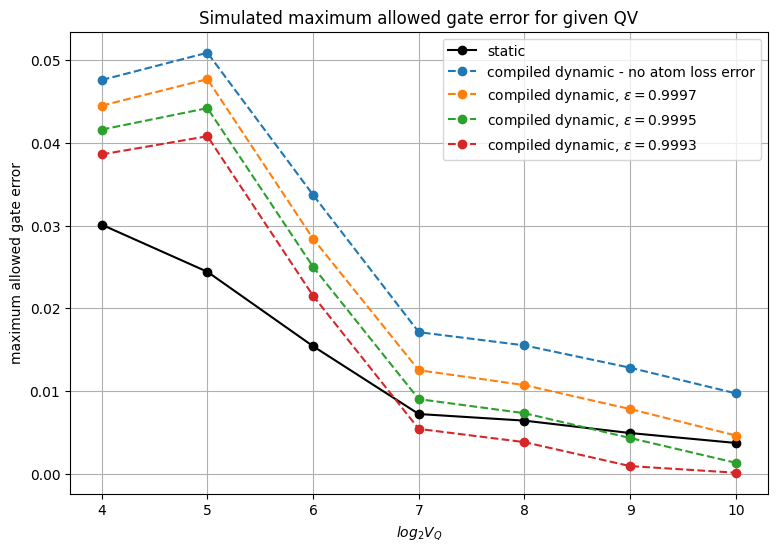

In [192]:
index = [0,1,2,3,4,5,6]
qv = np.array([4.,5.,6.,7.,8.,9.,10.])[index]
max_error_static = 1 - np.array([0.9699, 0.9756, 0.9846, 0.9928, 0.9936, 0.9951, 0.9963])[index]
max_error_dynamic = 1 - np.array([0.9524, 0.9491, 0.9663, 0.9829, 0.9845, 0.9872, 0.9903])[index]
max_error_dc95 = 1 - np.array([0.9584, 0.9558, 0.9750, 0.9910, 0.9927, 0.9957, 0.9987])[index]
max_error_dc97 = 1 - np.array([0.9555, 0.9523, 0.9716, 0.9875, 0.9893, 0.9922, 0.9954])[index]
max_error_dc93 = 1 - np.array([0.9614, 0.9592, 0.9785, 0.9946, 0.9962, 0.9991, 0.9999])[index]
#max_atom_error = 1 - np.array([0.9971, 0.9971, 0.9983, 0.9992, 0.9993, 0.9995, 0.9997])[index]
def fita(n, a, b):
    return 1 - (1 - 1/n**2)**(1/(n**b))

sparams, scov = curve_fit(fita,qv,max_error_dynamic,bounds=((0., 0.), (np.inf, np.inf)))
sfita, sfitb = sparams[0], sparams[1]

dcparams, dccov = curve_fit(fita,qv,max_error_static,bounds=((0., 0.), (np.inf, np.inf)))
dcfita, dcfitb = dcparams[0], dcparams[1]

splot = fita(qv, sfita, sfitb)
dcplot = fita(qv, dcfita, dcfitb)

print('static: ', sfita, sfitb, '\ndynamic: ', dcfita, dcfitb)
fig, ax = plt.subplots(figsize = (9, 6))

ax.plot(qv,max_error_static, 'o-', color = 'black', label = 'static')
ax.plot(qv,max_error_dynamic, 'o--',label = 'compiled dynamic - no atom loss error')
ax.plot(qv,max_error_dc97, 'o--',label = 'compiled dynamic, $\epsilon = 0.9997$')
ax.plot(qv,max_error_dc95, 'o--',label = 'compiled dynamic, $\epsilon = 0.9995$')
ax.plot(qv,max_error_dc93, 'o--',label = 'compiled dynamic, $\epsilon = 0.9993$')
#ax.plot(qv, max_atom_error, 'o--', label = 'compiled dynamic')
#ax.plot(qv,splot, '-',label = 'static fit')
#ax.plot(qv,dcplot, '-',label = 'compiled dynamic fit')
#ax.set_yscale('log')
plt.xlabel('$log_2V_Q$')
plt.ylabel('maximum allowed gate error')
plt.title('Simulated maximum allowed gate error for given QV')
plt.legend()
plt.grid()
plt.show()

In [8]:
max_qubits = 11
n_trials = min(999,2**max_qubits)
benchmark = 2./3.
atom_loss = 1
q_range = range(3,max_qubits+1)

# sampling cnot error probs
a1 =  np.logspace(-3, -2, 3)
a2 = np.arange(1,10,1)
err_probg = np.outer(a1, a2).flatten()
probg = 1 - np.outer(a1, a2).flatten()
print(len(probg),  np.sqrt((1 + probg**2)/2.), '\n', probg)

s_QV, du_QV, dc_QV, dau_QV, dac_QV = max_qubits+1, max_qubits+1, max_qubits+1, max_qubits+1, max_qubits+1
all_s_QV, all_du_QV, all_dc_QV, all_dau_QV, all_dac_QV = np.full((len(probg)),max_qubits+1), np.full((len(probg)),max_qubits+1), np.full((len(probg)),max_qubits+1), np.full((len(probg)),max_qubits+1), np.full((len(probg)),max_qubits+1)

plotn_cnots_du, plotn_cnots_dc, plotn_cnots_static = [0]*len(probg), [0]*len(probg), [0]*len(probg)

#calculating random initial states
init_amps, init_states = create_init_state(max_qubits)

27 [0.99950013 0.9990005  0.99850113 0.998002   0.99750313 0.99700451
 0.99650615 0.99600803 0.99551017 0.99842011 0.99684274 0.99526789
 0.99369557 0.9921258  0.9905586  0.98899396 0.98743191 0.98587246
 0.99501256 0.9900505  0.98511421 0.98020406 0.97532046 0.97046381
 0.96563451 0.96083297 0.95605962] 
 [0.999      0.998      0.997      0.996      0.995      0.994
 0.993      0.992      0.991      0.99683772 0.99367544 0.99051317
 0.98735089 0.98418861 0.98102633 0.97786406 0.97470178 0.9715395
 0.99       0.98       0.97       0.96       0.95       0.94
 0.93       0.92       0.91      ]


In [9]:
for j in range(len(probg)):

    print(j)
    atom_loss = 1. #0.9995
    cnot_prob = probg[j]
    s_QV, s_cnots, s_all_qubits_hps = hop_calc('s', max_qubits, init_amps, init_states, cnot_prob, atom_loss, n_trials)
    dc_QV, dc_cnots, dc_all_qubits_hps = hop_calc('dc', max_qubits, init_amps, init_states, cnot_prob, atom_loss, n_trials)
    du_QV, du_cnots, du_all_qubits_hps = hop_calc('du', max_qubits, init_amps, init_states, cnot_prob, atom_loss, n_trials)
    print(s_all_qubits_hps, dc_all_qubits_hps)
    all_s_QV[j], all_dc_QV[j] = s_QV, dc_QV
    all_du_QV[j] = du_QV
    
    plotn_cnots_static[j], plotn_cnots_dc[j] = s_cnots[s_QV-2], dc_cnots[dc_QV-2]
    plotn_cnots_du[j] = du_cnots[du_QV-2]

    all_s_QV[j], all_dc_QV[j] = s_QV, dc_QV
    all_du_QV[j] = du_QV


indices = np.argsort(-probg)
probg = probg[indices]
all_s_QV = all_s_QV[indices]
all_dc_QV = all_dc_QV[indices]
all_du_QV = all_du_QV[indices]
    

0


KeyboardInterrupt: 

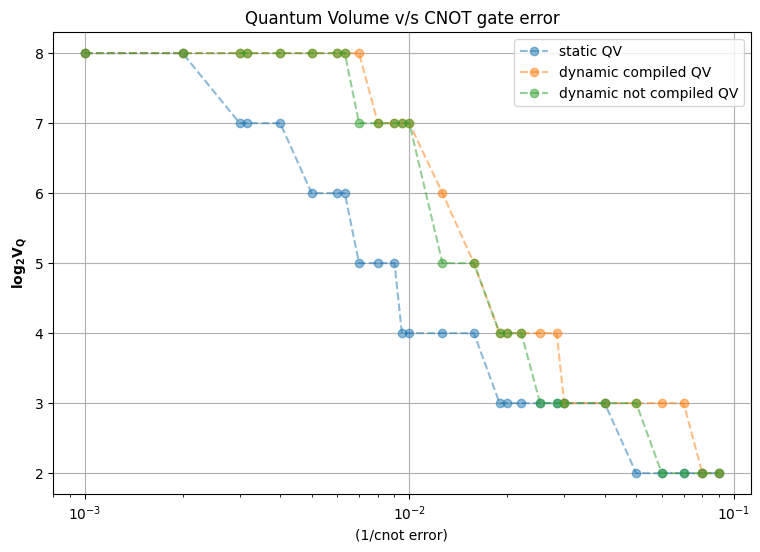

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))
alpha = 0.5
# ax.scatter(1. - probg, all_dc_QV, s=60, alpha=alpha, edgecolors="black", color = "blue")
# ax.scatter(1. - probg, all_s_QV, s=60, alpha=alpha, edgecolors="black", color = 'yellow')

ax.plot(1. - probg, all_s_QV, 'o--', alpha=alpha, label = 'static QV')
ax.plot(1. - probg, all_dc_QV, 'o--', alpha=alpha,label = 'dynamic compiled QV')
ax.plot(1. - probg, all_du_QV, 'o--', alpha=alpha, label = 'dynamic not compiled QV')
plt.grid()
plt.xlabel("(1/cnot error)")
plt.ylabel("$\mathbf{log_2V_Q}$")
plt.title("Quantum Volume v/s CNOT gate error")
plt.legend()
# Set logarithmic scale on the x variable
ax.set_xscale("log")

#ADD YOUR PATH HERE CHETANAAA
path = f"D:\\IITBombay\\useqip\\URA\\DIG\\quantum_volume\\plots"
plt.savefig(path + '/qvs_final' + str(max_qubits) + 'prob' + str(len(probg)) + '.png', bbox_inches = 'tight')
plt.show()

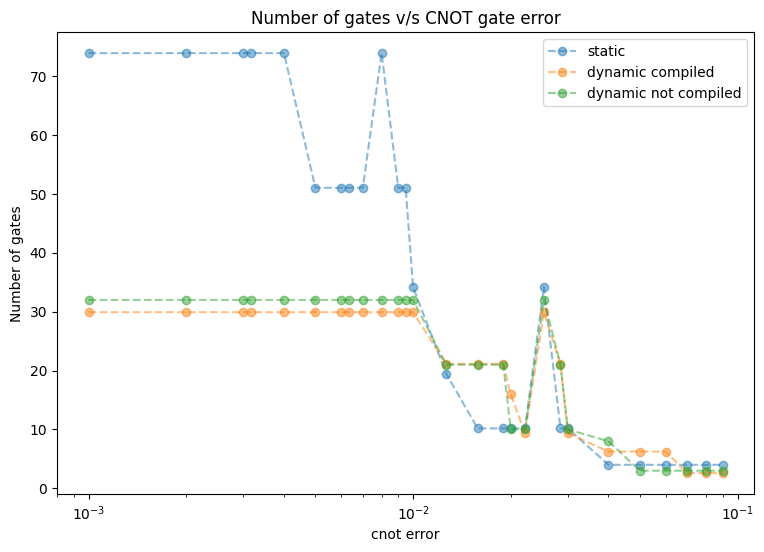

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))
alpha = 0.5
#ax.scatter(1. - probg, plotn_cnots_dynamic, s=60, alpha=alpha, edgecolors="black", color = "blue")
#ax.scatter(1. - probg, plotn_cnots_static, s=60, alpha=alpha, edgecolors="black", color = 'yellow')
ax.plot(1. - probg, plotn_cnots_static, 'o--', alpha=alpha,label = 'static')
ax.plot(1. - probg, plotn_cnots_dc, 'o--', alpha=alpha, label = 'dynamic compiled')
ax.plot(1. - probg, plotn_cnots_du, 'o--', alpha=alpha, label = 'dynamic not compiled')
plt.xlabel("cnot error")
plt.ylabel("Number of gates")
plt.title("Number of gates v/s CNOT gate error")

plt.legend()
# Set logarithmic scale on the x variable
ax.set_xscale("log")
#ax.set_yscale("log")

#ADD YOUR PATH HERE CHETANAAA
path = f"D:\\IITBombay\\useqip\\URA\\DIG\\quantum_volume\\plots"
plt.savefig(path + '/ncnots_final' + str(max_qubits) + 'prob' + str(len(probg)) + '.png', bbox_inches = 'tight')
plt.show()

In [ ]:
print('static QV: \n', all_s_QV[6:11])
print('dynamic QV: \n', all_dc_QV)
print('dynamic QV uncompiled: \n', all_du_QV)
print('probabilities \n', 1.-probg)

patht = f"D:\\IITBombay\\useqip\\URA\\DIG\\quantum_volume\\QVs"
Path(patht).mkdir(parents=True, exist_ok=True)
with open(patht + '/QV_final' + str(max_qubits) + 'prob_' + str(len(probg)) +'.txt', 'w+') as f:
    f.write(str(max_qubits) + '\n')
    f.write('probabilities: \n' +  str(1.-probg) + '\n')
    f.write('static QV: \n' + str(all_s_QV) + '\n')
    f.write('compiled dynamic QV: \n' + str(all_dc_QV) + '\n')
    f.write('uncompiled dynamic QV: \n' + str(all_du_QV) + '\n')
    f.write('static no. of cnots: \n' + str(plotn_cnots_static) + '\n')
    f.write('compiled dynamic  no. of cnots: \n' + str(plotn_cnots_dc) + '\n')
    f.write('uncompiled dynamic  no. of cnots: \n' + str(plotn_cnots_du) + '\n')

static QV: 
 [7 7 7 7 7]
dynamic QV: 
 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 7 7 7 6 5 5 4 4 4 3 3 3]
dynamic QV uncompiled: 
 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 7 7 7 5 5 5 4 3 3 3 3 3]
probabilities 
 [0.001      0.002      0.003      0.00316228 0.004      0.005
 0.006      0.00632456 0.007      0.008      0.009      0.00948683
 0.01       0.01264911 0.01581139 0.01897367 0.02       0.02213594
 0.02529822 0.0284605  0.03       0.04       0.05       0.06
 0.07       0.08       0.09      ]


In [126]:
#NO NEED TO RUN FROM HERE CHETANAAAAAAAAAAA


max_qubits = 7
n_trials = min(999,2**max_qubits)
benchmark = 2./3.
q_range = range(3,max_qubits+1)

# sampling cnot error probs
a1 =  np.logspace(-3, -2, 3)
b1 = np.logspace(-4, -3, 3)
a2 = np.arange(1,10,1)
err_probg = np.outer(a1, a2).flatten()
probg = 1 - np.outer(a1, a2).flatten()
a_probg = 1 - np.outer(b1, a2).flatten()
print(probg, a_probg)

s_QV, du_QV, dc_QV, dau_QV, dac_QV = max_qubits+1, max_qubits+1, max_qubits+1, max_qubits+1, max_qubits+1
all_s_QV, all_du_QV, all_dc_QV, all_dau_QV, all_dac_QV = np.full((len(probg), len(probg)),max_qubits+1), np.full((len(probg),len(probg)),max_qubits+1), np.full((len(probg), len(probg)),max_qubits+1), np.full((len(probg), len(probg)),max_qubits+1), np.full((len(probg), len(probg)),max_qubits+1)

plotn_cnots_du, plotn_cnots_dc, plotn_cnots_static = np.full((len(probg), len(probg)), 0), np.full((len(probg), len(probg)), 0), np.full((len(probg), len(probg)), 0)

#calculating random initial states
init_amps, init_states = create_init_state(max_qubits)

for j in range(len(probg)):

    print(j)
    cnot_prob = probg[j]

    for k in range(len(probg)):
        atom_loss = a_probg[k]

        s_QV, s_cnots, s_all_qubits_hps = hop_calc('s', max_qubits, init_amps, init_states, cnot_prob, atom_loss, n_trials)
        dc_QV, dc_cnots, dc_all_qubits_hps = hop_calc('dc', max_qubits, init_amps, init_states, cnot_prob, atom_loss, n_trials)
        #du_QV, du_cnots, du_all_qubits_hps = hop_calc('du', max_qubits, init_amps, init_states, cnot_prob, atom_loss, n_trials)
        all_s_QV[j][k], all_dc_QV[j][k] = s_QV, dc_QV
        #all_du_QV[j] = du_QV
        print(dc_QV, dc_all_qubits_hps)
        plotn_cnots_static[j][k], plotn_cnots_dc[j][k] = s_cnots[s_QV-2], dc_cnots[dc_QV-2]
        #plotn_cnots_du[j] = du_cnots[du_QV-2]

        all_s_QV[j][k], all_dc_QV[j][k] = s_QV, dc_QV
        #all_du_QV[j] = du_QV

indices = np.argsort(-probg)
probg = probg[indices]
all_s_QV[,:] = all_s_QV[indices]
all_dc_QV = all_dc_QV[indices]
all_du_QV = all_du_QV[indices]
    

[0.999      0.998      0.997      0.996      0.995      0.994
 0.993      0.992      0.991      0.99683772 0.99367544 0.99051317
 0.98735089 0.98418861 0.98102633 0.97786406 0.97470178 0.9715395
 0.99       0.98       0.97       0.96       0.95       0.94
 0.93       0.92       0.91      ] [0.9999     0.9998     0.9997     0.9996     0.9995     0.9994
 0.9993     0.9992     0.9991     0.99968377 0.99936754 0.99905132
 0.99873509 0.99841886 0.99810263 0.99778641 0.99747018 0.99715395
 0.999      0.998      0.997      0.996      0.995      0.994
 0.993      0.992      0.991     ]
0
7 [0.9797023600165351, 0.8115887981661756, 0.9413358332826343, 0.8470126527189582, 0.8616199294281691, 0.8527408656244853]
7 [0.97912666319709, 0.8100600395817277, 0.936549985127026, 0.8320638469658067, 0.8491115558942406, 0.8377207302500547]
7 [0.9782385024236617, 0.8082108518980227, 0.93193001284323, 0.8236530037907159, 0.8374911841139491, 0.8223011416174013]
7 [0.9774325459216222, 0.8066117030624129, 0.9268

In [127]:
print(all_dc_QV)

[[7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 5 4 4 7 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 5 4 4 7 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 5 4 4 7 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 5 4 4 7 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 7 7 7 7 7 6 5 5 5 4 4 6 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 7 7 7 7 6 6 5 5 5 4 4 6 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 7 6 7 7 6 6 5 5 4 4 4 6 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 7 6 7 7 6 6 5 5 4 4 4 6 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 6 6 7 7 6 6 5 5 4 4 4 6 5 4 4 4 3 3 2 2]
 [7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 5 4 4 7 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 7 7 7 7 6 6 5 5 5 4 4 6 5 4 4 4 4 3 2 2]
 [7 7 7 7 7 7 7 6 6 7 7 6 6 5 5 4 4 4 6 4 4 4 4 3 3 2 2]
 [7 7 7 7 7 6 6 6 6 7 6 6 5 5 4 4 4 4 6 4 4 4 4 3 3 2 2]
 [7 7 7 6 6 6 6 6 6 7 6 6 5 4 4 4 4 4 5 4 4 4 4 3 3 2 2]
 [7 6 6 6 6 6 6 5 5 6 6 5 5 4 4 4 4 4 5 4 4 4 4 3 3 2 2]
 [6 6 6 6 6 6 5 5 5 6 6 5 5 4 4 4 4 4 5 4 4 4 4 3 3 2 2]
 [6 6 6 6 5 5 5 5 5 6 5 5 4 4 4 4 4 4 5 4 4 4 3 3 2 2 2]
 [6 6 6 5 5 5 5 4 4 6 5 4 4 4 4

C:\Users\91939\AppData\Local\Temp\ipykernel_34184\1208931914.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  heatmap = ax.pcolormesh(1.-a_probg, 1.-probg, plot, norm=norm, cmap="RdBu_r")


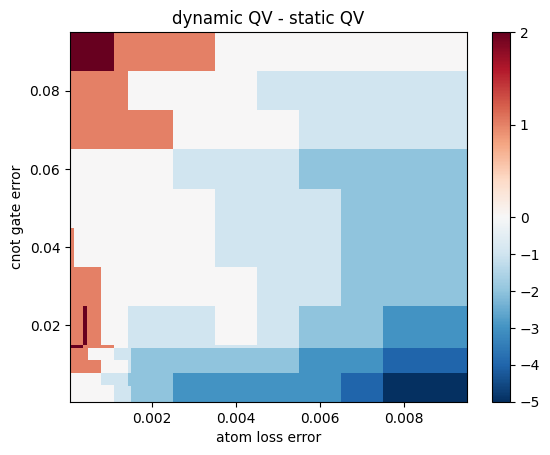

In [128]:

from matplotlib.colors import TwoSlopeNorm

plot =  all_dc_QV - all_s_QV
fig, ax = plt.subplots()

norm = TwoSlopeNorm(vmin=plot.min(), vcenter=0, vmax=plot.max())

heatmap = ax.pcolormesh(1.-a_probg, 1.-probg, plot, norm=norm, cmap="RdBu_r")
#plt.xscale('log')  # Set logarithmic scale for x-axis
#plt.yscale('log')  # Set logarithmic scale for y-axis
plt.colorbar(heatmap)  # Add colorbar
plt.xlabel('atom loss error')
plt.ylabel('cnot gate error')
plt.title('dynamic QV - static QV')
plt.savefig(path + '/2Dnew' + str(max_qubits) + 'prob' + str(len(probg)) + '.png', bbox_inches = 'tight')
plt.show()

In [ ]:
print('static QV: \n', all_s_QV)
print('dynamic QV: \n', all_dc_QV)
print('dynamic QV uncompiled: \n', all_du_QV)
print('probabilities \n', 1.-probg)

static QV: 
 [[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
 [4 4 4 6 4 6 4 6 4 4 4 4 4 4 4 4 4 6 4 6 4 6 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 

1/n^a:  [1.         3.60643164]
1/a*n^b:  [1.         2.92929782]


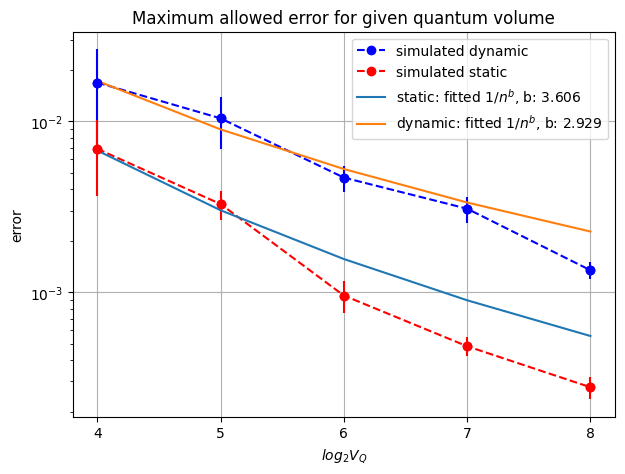

In [443]:
dynamic_max_errors = np.array([0.013419999999999, 0.008299999999, 0.003739999999, 0.002459999999, 0.001074000000000963])#, 0.000694800000001412
dynamic_max_errors_std = np.array([0.00955633, 0.0035454, 0.000819999, 0.000537028,  0.0001507448])#, 5.048722610e-5
dynamic_max_errors = 2 - np.sqrt(4 - 5*(dynamic_max_errors))
static_max_errors = np.array([0.005508000, 0.0026199, 0.00076400, 0.00038560, 0.00022200])
static_max_errors_std = np.array([0.00324, 0.0006289, 0.0002056, 6.119346370294897e-05, 4.142463035445739e-05])
static_max_errors = 2 - np.sqrt(4 - 5*(static_max_errors)) 
max_qubits = 8
m = np.array(range(4, max_qubits+1))
n = m*m//2

def simfit1(n,a,b):
    return 1/n**b

def simfit2(n,a,b):
    return 1/(a*n**b)

params_sim1, cov_sim1 = curve_fit(simfit1,m,static_max_errors,bounds=((0., 0.), (np.inf, np.inf)))
fit1a_sim, fit1b_sim = params_sim1[0], params_sim1[1]

params_sim2, cov_sim2 = curve_fit(simfit1,m,dynamic_max_errors,bounds=((0., 0.), (np.inf, np.inf)))
fit2a_sim, fit2b_sim = params_sim2[0], params_sim2[1]


print('1/n^a: ', params_sim1)
plot_sim1 = simfit1(m,fit1a_sim, fit1b_sim)

print('1/a*n^b: ', params_sim2)
plot_sim2 = simfit1(m,fit2a_sim, fit2b_sim)


# error1 = 1 - (1-1/m**2)**(1/(fit1a*m+fit1b))
# error2 = 1 - (1-1/m**2)**(1/(fit2a*m**3 + fit2b))
# error3 = 1 - (1-1/m**2)**(1/(fit3a*m**3 + fit3b*m+fit3c))
# error4 = 1 - (1-1/m**2)**(1/(fit4a*m**fit4b + fit4c))
# error5 = 1 - (1-1/m**2)**(1/(fit5a*m**3))
#error6 = 1 - (1-1/m**2)**(1/fit6(m,fit6a,fit6b,fit6c))

# rms1 = np.sqrt(np.sum((dynamic_max_errors - error1)**2))
# rms2 = np.sqrt(np.sum((dynamic_max_errors - error2)**2))
# rms3 = np.sqrt(np.sum((dynamic_max_errors - error3)**2))
# rms4 = np.sqrt(np.sum((dynamic_max_errors - error4)**2))
# rms5 = np.sqrt(np.sum((dynamic_max_errors - error5)**2))
# #rms6 = np.sqrt(np.sum((max_error_dynamic - error6)**2))

# rms = np.array([rms1, rms2, rms3, rms4, rms5])
# print(np.argmin(rms)+1, rms)


fig, ax = plt.subplots(figsize = (7, 5))
#ax.plot(m,error1,'o--', label = '$1-(1-err)^{Ax+B}$')
#ax.plot(m,error2,'o--', label = '$1-(1-err)^{Ax^3+B}$')
#ax.plot(m,error3, 'o--',label = '$1-(1-err)^{Ax^3+Bx+C}$')
#ax.plot(m,error4,'o--', label = '$1-(1-err)^{Ax^B+C}$')
#ax.plot(m,error5,'o--', label = '$1-(1-err)^{Ax^3}$')
ax.errorbar(m,dynamic_max_errors,yerr = dynamic_max_errors_std, fmt = 'o', color = 'blue')

ax.errorbar(m,static_max_errors,yerr = static_max_errors_std,fmt = 'o', color = 'red')
ax.plot(m,dynamic_max_errors,'o--', label = 'simulated dynamic', color = 'blue')
ax.plot(m,static_max_errors,'o--', label = 'simulated static', color = 'red')
ax.plot(m,plot_sim1, label = 'static: fitted $1/n^b$, b: %1.3f'%fit1b_sim)
ax.plot(m,plot_sim2, label = 'dynamic: fitted $1/n^b$, b: %1.3f'%fit2b_sim)
plt.xticks([4.,5.,6.,7.,8])
#ax.plot(fitme,errorfit)
ax.set_yscale('log')
plt.xlabel("$log_2V_Q$")
plt.ylabel("error")
plt.title("Maximum allowed error for given quantum volume")
plt.legend()
plt.grid()
